## Process a few data files and look at output prediction, for sanity check


In [4]:

import os
import numpy as np
import tensorflow as tf
import glob
import geopandas as gpd
import json
import configparser 
from sklearn.manifold import TSNE
import rioxarray as rioxr
import xarray as xr
# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import xarray as xr
import sys

import matplotlib.pyplot as plt
from skimage import exposure as skimage_exposure
import rasterio as rio

# # homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
# workdir = '/gpfs/home3/mizeboud/' #os.path.join(homedir,'github/AutomatedDamageDetection/')
# os.chdir(os.path.join(workdir,'preprocessing/scripts/train-vae/'))
# import dataset
# import tiles as ts

from joblib import Parallel, delayed

print('\n')

def parse_config(config):
    """ Parse input arguments from dictionary or config file """
    if not isinstance(config, dict):
        parser = configparser.ConfigParser(allow_no_value=True)
        parser.read(config)
        config = parser["train-VAE"]

    catPath = config['catalogPath']
    labPath = config['labelsPath']
    outputDir = config['outputDirectory']
    sizeTestSet = int(config['sizeTestSet'])
    sizeValSet = int(config['sizeValidationSet'])
    roiFile = config['ROIFile']
    bands = [int(i) for i in config['bands'].split(" ")]
    sizeCutOut = int(config['sizeCutOut'])
    sizeStep = int(config['sizeStep'])
    stride = int(config['stride'])
    #DATA
    # balanceRatio = float(config['balanceRatio'])
    # file_DMGinfo = config['tiledDamagePixelsCountFile']
    # normThreshold = [float(i) for i in config['normalizationThreshold'].split(" ")]
    normThreshold = config['normalizationThreshold']
    if normThreshold is not None:
        normThreshold = [float(i) for i in normThreshold.split(" ")]
    adaptHist = True if config['adaptHistogramEqual'] == 'True' else False
    

    return (catPath, labPath, outputDir, 
            bands, sizeCutOut, normThreshold, adaptHist,
            )


''' ------------
FUNCTIONS
--------------- '''

def normalise_and_equalise(da,normThreshold=None,equalise=False):
    
    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        n_bands = da['band'].shape[0]
        all_band_eq=np.empty(da.shape)

        for band_i in range(n_bands): # perform adaptive normalisation per band
            band_data = da.isel(band=band_i)
            band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
            all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

        da = da.copy(data=all_band_eq) # overwrite data in dataArray
    
    return da
    
def create_cutouts2(da,cutout_size, normThreshold=None, equalise=False):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    # tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    # tile_cutouts_da = da.transpose('sample','x_win','y_win','band')

    tile_cutouts_da = da.transpose('sample','x_win','y_win' ,...) # transpose dimensionos; dataArray does nto necessarily need 'band' as dimension
    tile_cutouts = tile_cutouts_da.data
    
    return tile_cutouts, tile_cutouts_da

def mask_data(data, mask_file):
    mask_poly = gpd.read_file(mask_file).to_crs(epsg=3031)
    # gdf = mask_poly.unary_union 
    # mask = data #.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
    masked_data = data.rio.clip(mask_poly.unary_union, mask_poly.crs, drop=False, invert=False) # mask (raster)
    return masked_data

  
def plot_latentspace_clusters( embedded_data,labels, clabel,figsize=(8,8) ):    
    marksize = 2
    if len(labels.shape)>1:
        labels = np.squeeze(labels)
    
    # sort data with label value
    embedded_data = embedded_data[ np.argsort(labels),:] #,np.argsort(labels)]
    labels = np.sort(labels,axis=0)
    
    # split data in points with (no) label value
    z0 = embedded_data[:, 0]
    z1 = embedded_data[:, 1]
    
    fig, ax1 = plt.subplots(figsize=figsize )
    s1 = ax1.scatter(z0, z1, c=labels, s=marksize, cmap='cividis_r') 
    ax1.set_xlabel("z[0]"); 
    ax1.set_ylabel("z[1]");
    fig.colorbar(s1,ax=ax1,label=clabel); 
    
    return fig



''' -------------

   Tile processing function
   
-----------------'''

def predict_and_save_tile( tiles_path, tileNum, 
                            encoder, model_dir, epoch_num, 
                            bands , cutout_size, normThreshold, adaptHist,
                            path2save='./'  ) :

    ## filename of current tile
    tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
    tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
    
    ## Filename of prediction
    tilePredict_fileName = '{}_model_{}_epoch{}_predict.tif'.format(tileName,model_dir.split('_')[1],epoch_num)
    
#     if os.path.exists( os.path.join(path2save, tilePredict_fileName )):
#         print('Already predicted tile {}; continue'.format(tileNum))
#         # continue
#     else: 
#         print('----\n Processing ' + tileName )
        
#         if not os.path.isfile(tile_file):
#             print('----\n No tile found for {}; continue'.format(tileNum))
#         else:
#             print('.. do processing')
            
    return tile_file, tilePredict_fileName

# def define_prediction_filename(image_filepath, model_dir, epoch_num ):
#     # tile_file = os.path.join(tiles_path,'S2_composite_2019-11-1_2020-3-1_tile_' + str(tileNum) + '.tif')
#     # tileName = image_filepath.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
#     image_filename = image_filepath.stem # /path/to/img_file.tif --> img_file
#     model_id = model_dir.split('_')[1] # model_1684233861_L2_w20_k5_f16_a20... --> model_1684233861
    
#     predict_fileName = '{}_model_{}_epoch{}_predict.tif'.format(image_filename,model_id,epoch_num)
    
            
def process_image( image_file, predict_fileName,
                    encoder, model_dir, epoch_num, 
                    bands , cutout_size, normThreshold, adaptHist,
                    path2save=None  ) :
    
    ''' ----------
    Create cut-outs
        Actually read the tile, make cutouts, linked with labeldata
    ------------'''
    
    # if not os.path.isfile(image_file):
    #     print('----\n No tile found for {}; continue'.format(tileNum))
    #     # continue
    # else:

    with rioxr.open_rasterio(image_file).astype("float32") as da:

        # select bands
        if bands is not None:
            if type(bands) is not list:
                da = da.sel(band=[bands])
            else:
                da = da.sel(band=bands)


        ''' ----------
        Mask ocean
        - not required for predicting -- so do lateron 
        ------------'''

        # mask/clip: if self.mask is not None: [removed; see _generate_cutouts]
        # da = mask_data(da,oceanmask_file)


        ''' ----------
        Normalise and Equalise
        ------------'''

        da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=adaptHist)
        print('.. normalised data')

        ''' ----------
        Create cut-outs
        - First fill NaN values so that they are not dropped during cut-out construction
        - Store a mask of the NaN values so that they can be returned later
        ------------'''

        ## Create mask -- by omitting the ocean-mask step, there are no NaN values expectedi n the data. 
        # We could mask them, but then also need to aggregate them to window-values to be able to put them on the labels later. Seems like unnecessary steps if it is not needed.
        if np.isnan(da).any():
            mask_nan = np.isnan(da).sum(dim='band') # .astype(bool)
            da = da.fillna(-999)
            # raise ValueError('Tiledata has NaN values -- need to mask these')
            mask_nan_cutouts = create_cutouts2(mask_nan,cutout_size).sum(axis=1).sum(axis=1) # has value > 0 if any px in window has a NaN value
            mask_nan_pred = mask_nan_cutouts.where(mask_nan_cutouts == 0, 1).astype(bool) # yields True (1) for nan-containing windows
        else:
            mask_nan_pred = None

        # generate windows -- cut 
        _, tile_cutouts_da = create_cutouts2(da,cutout_size) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
        # print('cutouts {} '.format(tile_cutouts.shape))


        ''' ----------
        Encode data
        ------------'''

        encoded_data,_,_ = encoder.predict(tile_cutouts_da.data);

        z0 = encoded_data[:,0]
        z1 = encoded_data[:,1]

        ''' ----------------------------------------
        Predict cluster type for all pixels: Threshold
        -----------------------------------------------'''

        ## Sort latent space values so can threshold values of Z1 based on Z0
        i_sort = np.argsort(z0)
        z1_sorted = z1[i_sort]
        z0_sorted = z0[i_sort]

        # set up sequence for x-axis
        z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )

        ## Define cluster (all samplesa bove threshold) 

        if model_dir == 'model_1684233861_L2_w20_k5_f16_a20' and epoch_num == '9': # for model_1684233861 (16 may 23)
            dzdz = (0.005)/(1)
            dzdz = (0.06)/2
            c = 0.01 #0 
            z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )
            z1_treshold_val = dzdz*z0_seq + c 

            # -- extract samples in cluster
            # idx_cluster_sorted = np.less(z1_sorted, z1_treshold_val).astype(int)
            idx_cluster_sorted = np.greater(z1_sorted, z1_treshold_val).astype(int)
            print('Extract samples GREATER THAN line: Z1 = {:.2f}*Z0 + {:.2f}'.format( dzdz, c ) ) 

        else:
            raise ValueError('Cluster extraction method is not defined for specified model {} -- update code', model_dir)

        ## -- Reverse sort of latent space to recover spatial relations of samples
        idx_cluster = idx_cluster_sorted[np.argsort(i_sort)] # (Nsamples,)


        ''' ----------
        Put predicted labels in dataArray; plot and save
        ------------'''

        ## place the cluster indices in an xarray and unstack to spatial img
        idx_cluster_da = tile_cutouts_da.isel(band=0,x_win=0,y_win=0).copy(deep=True, data=idx_cluster) # (Nsamples)
        cluster_da     = idx_cluster_da.unstack().transpose('y','x') # (Nsamples) --> (x, y) 

        ## Re-apply nan mask
        if mask_nan_pred:
            cluster_da = cluster_da.where(~mask_nan,np.nan)

        # ## Plot
        # fig,ax=plt.subplots(figsize=(6,5))
        # cluster_da.plot.imshow(ax=ax,label=''); ax.set_axis_off(); ax.set_title('');

        ### Save
        cluster_da = cluster_da.astype('uint8') # convert binary data to byte (otherwise loading error from GCS to GEE)
        # cluster_da.rio.to_raster(  os.path.join(path2save, predict_fileName ), driver="COG") # use CloudOptimisedGeotiff so it can be used together with GEE
        # print('Save predicted tile to {}'.format(predict_fileName))
        # # print('----')

        return encoded_data, cluster_da


In [11]:

print('---- Config -----')

homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
encoder_dir = os.path.join(homedir,'github/AutomatedDamageDetection/training/2023-05/model_1684233861_L2_w20_k5_f16_a20/encoder_epoch_9/')
data_dir = os.path.join(homedir,'github/AutomatedDamageDetection/data_tmp/')

---- Config -----


In [15]:


''' -------------

   MAIN
   
-----------------'''
    


''' ----------
Get model to load
------------'''

if encoder_dir is None:
    raise NameError('No encoder specified. Run script as "python this_script.py /path/to/model_dir/encoder_dir"')

if encoder_dir[-1] == '/': # trailing slash gives an error somewhere lateron; remove
    encoder_dir = encoder_dir[:-1]
# Update relative path to full path if needed
if os.path.isdir(encoder_dir):
    path_to_encoder_epoch = encoder_dir
else:
    path_to_encoder_epoch = os.path.join(os.path.expanduser('~'), encoder_dir)

## Retrieve master directory and its name
path_to_model = os.path.split(path_to_encoder_epoch)[0]
model_dir = os.path.basename(path_to_model)

print(path_to_model, model_dir )

''' ----------
Get path to data to process; define path to save predictions
--------------'''
if data_dir is None:
    data_dir = '/projects/0/einf512/S2_composite_2019-11-1_2020-3-1'
    print('.. No path to data specified; assuming same path as train-data: {}'.format(tiles_path) )
else:
    print('.. Reading data from     {}'.format(data_dir))

if data_dir[-1] == '/': # trailing slash gives an error somewhere lateron; remove
    data_dir = data_dir[:-1]
        
## Define path to save data
data_identifier = data_dir.split('/')[-1]
# path2save = os.path.join('/projects/0/einf512/VAE_predictions/',data_identifier)
# if not os.path.isdir(path2save):
#     print('.. Creating savepath directory')
#     os.makedirs(path2save, exist_ok=False)

# path2save = '/projects/0/einf512/VAE_predictions/S2_composite_2019-11-1_2020-3-1/'
# print('.. Save predictions to:  {}'.format(path2save) )
tiles_path = data_dir

''' ----------
Parse input arguments
------------'''
# config = glob.glob(path_to_traindir + "train-vae.ini")
# config = os.path.join(path_to_model,'train-vae.ini')
config = glob.glob(os.path.join(path_to_model,'*.ini'))

if not config:
    raise ValueError('Did not find configfile in directory', path_to_model)

# catPath, labPath, outputDir, sizeTestSet, sizeValSet, roiFile, \
#         bands, cutout_size, nEpochmax, nEpochTrain, sizeStep, stride, file_DMGinfo, normThreshold,adaptHist, \
#         filter1, filter2, kernelSize1, kernelSize2, denseSize, latentDim, \
#         alpha, batchSize,learnRate = parse_config(config)
catPath, labPath, outputDir, \
        bands, cutout_size, normThreshold, adaptHist = parse_config(config)


''' ----------
Load model/encoder
------------'''

print('.. Loaded encoder       {}'.format(path_to_encoder_epoch) )

epoch_num = path_to_encoder_epoch.split('_')[-1]
encoder = tf.keras.models.load_model(path_to_encoder_epoch,compile=False) # compile=True does not work

# Get latent_dim (of sampling layer)
latent_dim = encoder.layers[-1].output_shape[-1] 



''' ----------
Get files to process
--------------'''

file_list = glob.glob(os.path.join(data_dir, '*.tif'))

tile_filelist = [fname for fname in file_list if '_tile_' in fname]
img_filelist = [fname for fname in file_list if not '_tile_' in fname]

print('.. Tile files in dir: {}, other files: {}'.format(len(tile_filelist), len(img_filelist) ) )



# if tile_filelist: # if non-empty list: process tile_files

#     # TRAINIING tilenums
#     # tile_nums = [102,110,114,123,124,139,140,142,205,206,214,228,238,250,268,273,28,282,285,291,301,302,307,50,68,93]
#     # tile_nums = [28, 50,53,123,124,140] # 68, 102,110,114,123,124]
#     # tile_nums = [28, 50, 140] # with new manual AND nerd-labels
#     # tile_nums = [140] # with new manual AND nerd-labels

#     # TEST tilenums
#     #tile_nums = [0, 3, 4, 42, 51, 52, 53, 54, 55, 61, 124, 140, 276, 285, 286] # all tiles in DJF 19-20 tht have mnual labels

#     # ALL tiles
#     tile_nums = np.arange(58,63) # (0,313)

#     # Parallel(n_jobs=5)(delayed( predict_and_save_tile)( tiles_path, tileNum, 
#     #                         encoder, model_dir, epoch_num, 
#     #                         bands , cutout_size, normThreshold, adaptHist,
#     #                         path2save=path2save )
#     #                     for tileNum in tile_nums )

#     print('---- Processing -----')

#     for tileNum in tile_nums:
        
#         # predict_and_save_tile( tiles_path, tileNum, 
#         #                     encoder, model_dir, epoch_num, 
#         #                     bands , cutout_size, normThreshold, adaptHist,
#         #                     path2save=path2save  )
        
#         tile_file, tilePredict_fileName = predict_and_save_tile( tiles_path, tileNum, 
#                             encoder, model_dir, epoch_num, 
#                             bands , cutout_size, normThreshold, adaptHist,
#                             path2save=path2save  )
        
#         if os.path.exists( os.path.join(path2save, tilePredict_fileName )):
#             print('Already predicted tile {}; continue'.format(tileNum))
#             # continue
#         else: 
#             print('----\n Processing ' + tile_file )

#             if not os.path.isfile(tile_file):
#                 print('.. No tile found for {}; continue\n--'.format(tile_file))
#             else:
#                 process_image( tile_file, tilePredict_fileName,
#                     encoder, model_dir, epoch_num, 
#                     bands , cutout_size, normThreshold, adaptHist,
#                     path2save=path2save  )

        

# elif img_filelist:
    # print('---- Processing -----')
        
    # for image_filepath in img_filelist:
        
    #     image_filename = pathlib.Path(image_filepath).stem # /path/to/img_file.tif --> img_file
    #     model_id = model_dir.split('_')[1] # model_1684233861_L2_w20_k5_f16_a20... --> model_1684233861

    #     predict_fileName = '{}_model_{}_epoch{}_predict.tif'.format(image_filename,model_id,epoch_num)
        
    #     # if os.path.exists( os.path.join(path2save, predict_fileName )):
    #     #     print('Already predicted file {}; continue'.format(image_filename))
    #     #     continue
        
    #     print('----\n Processing ' + image_filename )

        
    #     encoded_data, cluster_da = process_image( image_filepath, predict_fileName,
    #             encoder, model_dir, epoch_num, 
    #             bands , cutout_size, normThreshold, adaptHist,
    #             path2save= None  ) 
            
        
    
print('----\nDone')




/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2023-05/model_1684233861_L2_w20_k5_f16_a20 model_1684233861_L2_w20_k5_f16_a20
.. Reading data from     /Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/data_tmp
.. Loaded encoder       /Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2023-05/model_1684233861_L2_w20_k5_f16_a20/encoder_epoch_9
.. Tile files in dir: 4, other files: 5
----
Done


In [16]:
img_filelist

['/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/data_tmp/S2_MGRStile_20191230T063819_20191230T063821_T36DWG.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/data_tmp/S2_MGRStile_20191230T031609_20191230T031609_T45DVE.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/data_tmp/S2_MGRStile_20191230T031609_20191230T031609_T45DWE.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/data_tmp/S2_MGRStile_20191230T063819_20191230T063821_T35DNA.tif',
 '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/data_tmp/S2_MGRStile_20191230T164349_20191230T164347_T09CWS.tif']

In [17]:
print('---- Select an image -----')
    
# for image_filepath in img_filelist:
image_filepath = img_filelist[0]

image_filename = pathlib.Path(image_filepath).stem # /path/to/img_file.tif --> img_file
model_id = model_dir.split('_')[1] # model_1684233861_L2_w20_k5_f16_a20... --> model_1684233861

predict_fileName = '{}_model_{}_epoch{}_predict.tif'.format(image_filename,model_id,epoch_num)

print('.. Processing ' + image_filename )


encoded_data, cluster_da = process_image( image_filepath, predict_fileName,
        encoder, model_dir, epoch_num, 
        bands , cutout_size, normThreshold, adaptHist,
        path2save= None  ) 
    


---- Select an image -----
.. Processing S2_MGRStile_20191230T063819_20191230T063821_T36DWG
.. normalised data
Extract samples GREATER THAN line: Z1 = 0.03*Z0 + 0.01


<xarray.DataArray (y: 760, x: 760)>
array([[0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1]], dtype=uint8)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * x            (x) float64 1.117e+06 1.117e+06 ... 1.268e+06 1.269e+06
  * y            (y) float64 1.812e+06 1.811e+06 1.811e+06 ... 1.66e+06 1.66e+06

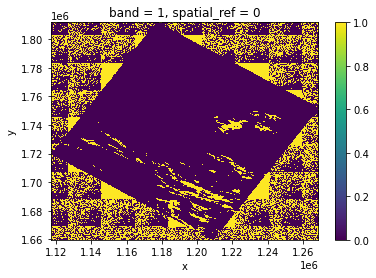

In [21]:
encoded_data
cluster_da.plot.imshow()
cluster_da

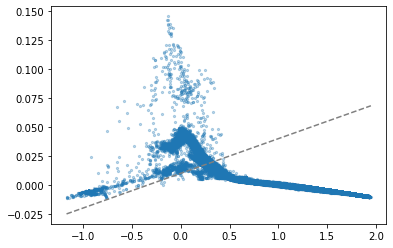

In [25]:
# plot_latentspace_clusters
z0 = encoded_data[:,0]
z1 = encoded_data[:,1]


## Sort latent space values so can threshold values of Z1 based on Z0
i_sort = np.argsort(z0)
z1_sorted = z1[i_sort]
z0_sorted = z0[i_sort]

# set up sequence for x-axis
z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )

## Define cluster (all samplesa bove threshold) 

if model_dir == 'model_1684233861_L2_w20_k5_f16_a20' and epoch_num == '9': # for model_1684233861 (16 may 23)
    dzdz = (0.005)/(1)
    dzdz = (0.06)/2
    c = 0.01 #0 
    z0_seq = np.linspace(np.nanmin(z0),np.nanmax(z0),len(z0) )
    z1_treshold_val = dzdz*z0_seq + c 

fig,ax=plt.subplots(1)
ax.scatter(z0,z1,5,alpha=0.3)
ax.plot(z0_seq,z1_treshold_val,'--',color='gray')


# DEV

In [ ]:
raise RuntimeError('Stop here')


In [1]:
import os
# os.chdir('/Users/tud500158/Documents/github/AutomatedDamageDetection/scripts/train-vae/')
# print(os.getcwd())
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
workdir = os.path.join(homedir,'github/AutomatedDamageDetection/')
os.chdir(os.path.join(workdir,'scripts/train-vae/'))
import numpy as np
import tensorflow as tf
import glob
import geopandas as gpd
import json
import configparser 
from sklearn.manifold import TSNE
import rioxarray as rioxr
import xarray as xr
import os
import matplotlib.pyplot as plt
import dataset
import tiles as ts

# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import xarray as xr

print('---- modules imported')
os.chdir(workdir)


---- modules imported


In [3]:

# # path_to_traindir = './model_v0/train_epoch_2/' # path on local computer
# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-12') # path on local computer
# # path_to_traindir = './train/model_v0/train_epoch_2/' # path on cartesius
ini_file = 'train-vae.ini'

# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-12') # path on local computer
# model_dir = 'model_1652389459' # VAE-b-L2-n2
# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-19') # path on local computer
# model_dir = 'model_1652994000' # VAE-b-L2-n20
# path_to_traindir = os.path.join(os.getcwd(), 'training','2022-05-19') # path on local computer
# model_dir = 'model_1652995389' # VAE-b-L4-n2

# -- OKTOBER
# path_to_traindir = os.path.join(workdir, 'training','2022-10') # path on local computer
# # model_dir = 'model_1664876184' # VVAE with hist-equal input; applied to windows
# model_dir = 'model_1665487140' # VAE with hist-equal input; applied to img, alpha=2000

# path_to_traindir = os.path.join(workdir, 'training','2022-10/2022-10-04') # path on local computer
# model_dir = 'model_1664891181' # VAE with hist-equal input: applied to windows --> higher alpha


# -- NOV
path_to_traindir = os.path.join(workdir,'training','2022-11','2022-11-03')
model_dir = 'model_1667483750' # 3 nov
# model_dir = 'model_1667487343' # 3 nov

# ---------
config = os.path.join(path_to_traindir,model_dir,'train-vae.ini')

catPath, labPath, outputDir, sizeTestSet, sizeValSet, roiFile, \
        bands, cutout_size, nEpochmax, nEpochTrain, sizeStep, stride, file_DMGinfo, normThreshold, \
        filter1, filter2, kernelSize1, kernelSize2, denseSize, latentDim, \
        alpha, batchSize,learnRate = parse_config(config)
            

# local maachine: overwrite caatalogpath and labelspath
# catalog_path = '/Users/tud500158/Documents/Data/tiles'
# labels_path ='/Users/tud500158/Documents/PhD/crevasseDetection/GoogleEarth/labels/geojson/EPSG4326/'
catalog_path = os.path.join(homedir,'Data/tiles')
labels_path =os.path.join(homedir,'PhD/crevasseDetection/GoogleEarth/labels/geojson/EPSG4326/')


In [4]:
os.path.join(path_to_traindir , 'model*')
glob.glob(os.path.join(path_to_traindir , model_dir))
# path_to_traindir

['/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/training/2022-11/2022-11-03/model_1667483750']

In [24]:
testPath = os.getcwd()
thePath, fname = os.path.split(testPath)
os.path.split(testPath)[-1]

'AutomatedDamageDetection'

# Data

In [10]:

''' ----------
tmp: select 1 tile as tilelist
------------'''
# tile_list = [tile_list[1]]
# tile_list = [tile_list[-1]]
# tile_list

tile_file = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif',



# Read data, Create cutouts

In [14]:
# mask ROI (ocean)
import geopandas as gpd

# if self.mask is not None:
#     mask = self.mask.to_crs(da.spatial_ref.crs_wkt)
#     geometry = mask.unary_union.buffer(self.buffer)
#     # da = da.rio.clip([geometry], drop=True, invert=self.invert,
#     #                  all_touched=self.all_touched)
#     da = da.rio.clip([geometry], drop=False, invert=self.invert, # if mask defined, do not drop
#                      all_touched=self.all_touched)
def mask_data(data, mask_file):
    mask_poly = gpd.read_file(mask_file).to_crs(epsg=3031)
    # gdf = mask_poly.unary_union 
    # mask = data #.copy(data=np.ones_like(data.values)) # set up img with only 1 vluess
    masked_data = data.rio.clip(mask_poly.unary_union, mask_poly.crs, drop=False, invert=False) # mask (raster)
    return masked_data


In [16]:

''' ----------
Create cut-outs
    Actually read the tile, make cutouts, linked with labeldata
    
Update: do not link laabldata; now read same-tile NERD output
------------'''


''' ----------
Get tile
------------'''

# tile 124 is a training tile
tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_124.tif')
dmg_file = os.path.join(path_to_dmg, 'S2_composite_2019-11-1_2020-3-1_tile_124_300m_damageContin.tif')
# tile 285 is also a training t ile
# tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_285.tif')
# tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_110.tif')
# tile_file = os.path.join(homedir,'Data/tiles/training_tiles/S2_composite_2019-11-1_2020-3-1_tile_50.tif')

mask_file = os.path.join(homedir,'Data/ne_10m_antarctic_ice_shelves_polys/ne_10m_antarctic_ice_shelves_polys.shp')    


tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
print('\n----\n Processing ' + tileName +'\n')

# read tile - floats are required to mask with NaN's
da = rioxr.open_rasterio(tile_file).astype("float32")

# select bands
if bands is not None:
    if type(bands) is not list:
        da = da.sel(band=[bands])
    else:
        da = da.sel(band=bands)


''' ----------
Get DMG
------------'''
tile_dmg = rioxr.open_rasterio(os.path.join(path_to_dmg, dmg_file)).astype("float32")

# interpolate dmg to same resolution as tile (to link as labels)
tile_dmg_int = tile_dmg.isel(band=0).interp_like(da.isel(band=0))
tile_dmg_int= tile_dmg_int.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim
    
''' ----------
Mask ocean
------------'''
# mask/clip: if self.mask is not None: [removed; see _generate_cutouts]
da_origin = da.copy()
# da = mask_data(da,mask_file)
# da_mask = da.copy()

''' ----------
Normalise and Equalise
------------'''

# da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=False)
# da_norm_equal = da.copy()

''' ----------
Create cut-outs
------------'''

# generate windows -- cut 

tile_cutouts, tile_cutouts_da = create_cutouts2(da,cutout_size) # samples, x_win, y_win, bands: (250000, 20, 20, 1)
label_cutouts, __ = create_cutouts2(tile_dmg_int, cutout_size)

print(tile_cutouts.shape)
print(label_cutouts.shape)




----
 Processing S2_composite_2019-11-1_2020-3-1_tile_124

(15625, 100, 100, 3)
(15625, 100, 100, 1)


In [ ]:
print('nandata in:')
print('da original: {} \n da masked: {} \n da norm/equal: {} '.format(np.isnan(da_origin).any().values, np.isnan(da_mask).any().values, np.isnan(da_norm_equal).any().values ))

In [ ]:
nanmask = np.isnan(da)

In [ ]:
fig,ax= plt.subplots(1,2,figsize=(10,8))
da_origin.attrs['long_name']='imgbands';
da_origin.isel(band=0).plot.imshow(ax=ax[0])
ax[0].set_title('img, not normalised')
da_norm_equal.isel(band=0).plot.imshow(ax=ax[1],vmin=0,vmax=1,cbar_kwargs={"fraction": 0.046})
ax[1].set_title('img, normalised and equalised')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

# Plot encoded representation

We can also have a look at the 128-dimensional encoded representations. 
These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.

# Embed latent space

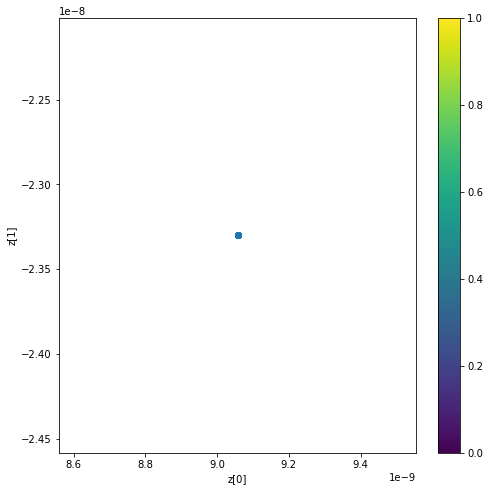

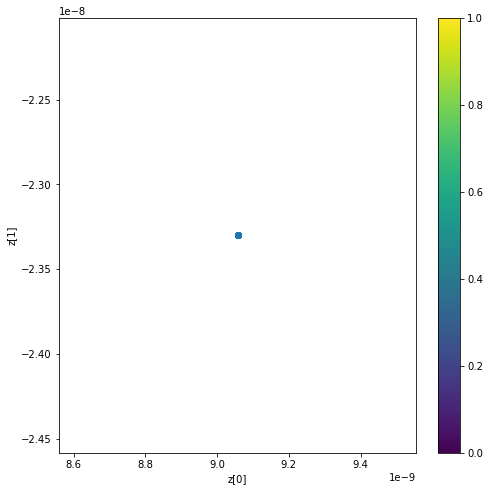

In [30]:

import matplotlib.colors as colors

''' ----------
Plot clustering
------------'''
  
    

def plot_latentspace_clusters_no_labels( embedded_data ):#,labels):
    ''' Embedded data should have (N,2)'''
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1])#, c=labels,s=2,cmap='winter') # also add size for scatter point
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    return fig
    


# fig = plot_latentspace_clusters_no_labels( embedded_data[:,0:2] )
# fig.savefig(os.path.join(path_to_traindir , model_dir, 'embedded_testdata_nolabels_' + tileNum))
